# Project Guide Line notebook 

## Import Pckages 

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
from sklearn import preprocessing
import data_loader
import feature_engineer 
import data_generator
import sequential 
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import math

## Data Loading and some fundmental Cleaning

In [2]:
place_holder = os.getcwd()
files  = ['/DATASET3_price.csv','/DATASET3_sales.csv','/DATASET3_stock.csv',
          '/Dataset3_Product.psv', 
          '/Dataset3_Product Hierarchy.psv']
name = ['price','sales','stock','product','hie']

* Please note that Feature Engineering is automatically completed for all features at one go 
* Using the data generator function

In [3]:
forecasting_peroid = 12
train, test = data_generator.data_generator(files,name,place_holder,forecasting_peroid) 

There are 8239 products in the our final data set
There are 92 weeks in the our final data set


In [4]:
train['reporting_date'] = pd.factorize(train['reporting_date'])[0] + 1
test['reporting_date'] = pd.factorize(test['reporting_date'])[0] + train['reporting_date'].max() + 1

In [5]:
print('train data has week range{}'.format(train['reporting_date'].unique()))
print('valid data has week range{}'.format(test['reporting_date'].unique()))

train data has week range[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80]
valid data has week range[81 82 83 84 85 86 87 88 89 90 91 92]


In [6]:
# Concat the train and test back together for future use 
data = pd.concat([train,test])

In [7]:
# Build the Base Line model for future comparison
MAE_b = []
R2_b = []
for week in list(test['reporting_date'].unique()):

    train = data[data['reporting_date'] < week]
    valid = data[data['reporting_date'] == week]

    p = valid['sales_quantity(t-1)'].values

    error = mean_absolute_error(valid['sales_quantity'].values, p)
    r2 = r2_score(valid['sales_quantity'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    print('Week %d - R2 %.5f' % (week, r2))
    MAE_b.append(error)
    R2_b.append(r2)
print('Mean Absolute Error = %.5f' % np.mean(MAE_b))
print('R2 = %.5f' % np.mean(R2_b))

Week 81 - Error 2.91245
Week 81 - R2 0.88903
Week 82 - Error 3.43681
Week 82 - R2 0.81684
Week 83 - Error 3.16711
Week 83 - R2 0.86313
Week 84 - Error 4.77957
Week 84 - R2 0.44312
Week 85 - Error 4.65534
Week 85 - R2 0.56082
Week 86 - Error 4.77638
Week 86 - R2 0.72724
Week 87 - Error 3.58425
Week 87 - R2 0.86386
Week 88 - Error 3.40389
Week 88 - R2 0.82738
Week 89 - Error 3.95702
Week 89 - R2 0.70695
Week 90 - Error 3.79661
Week 90 - R2 0.83021
Week 91 - Error 3.40772
Week 91 - R2 0.88691
Week 92 - Error 5.21321
Week 92 - R2 0.66360
Mean Absolute Error = 3.92420
R2 = 0.75659


## Data Spliting and standardisation

In [8]:
train_X, train_y = train.drop(columns = ['sales_quantity']), train['sales_quantity']
test_X, test_y = test.drop(columns = ['sales_quantity']), test['sales_quantity']

In [9]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

train_X_s = pd.DataFrame(X_scaler.fit_transform(train_X), columns = train_X.columns,index = train_X.index )
test_X_s = pd.DataFrame(X_scaler.transform(test_X), columns = test_X.columns,index = test_X.index)
#train_X_s.head()

In [10]:
#test_X_s.head()

In [11]:
train_y_s = pd.Series(y_scaler.fit_transform(np.array(train_y).reshape(-1, 1)).flatten(), index = train_y.index)
test_y_s = pd.Series(y_scaler.transform(np.array(test_y).reshape(-1, 1)).flatten(), index = test_y.index)

## Single Week Model Evaluation & PCA Component Selection

### Ridge Chart

In [12]:
MAE_train = []
MAE_valid = []
R2_train = []
R2_valid = []
for i in range(1,len(train_X_s.columns)+1): 
    pca = PCA(n_components=i)

    reg = Ridge(10)
    reg.fit(pca.fit_transform(train_X_s),train_y_s)
    predict_train = reg.predict(pca.fit_transform(train_X_s))

    # Performance on Train 
    # scale back and see the result on the train set
    predict_train_sb = y_scaler.inverse_transform(predict_train)
    train_y_s_sb = y_scaler.inverse_transform(train_y_s)

    MAE_train.append(mean_absolute_error(train_y_s_sb,predict_train_sb))
    R2_train.append(r2_score(train_y_s_sb,predict_train_sb))

    # Performance on Test
    # scale back and see the result on the test set

    predict_valid_81 = reg.predict(pca.transform(test_X_s[test_X_s['reporting_date'] == test_X_s    ['reporting_date'].unique()[0]]))   
    predict_valid_81_sb = y_scaler.inverse_transform(predict_valid_81)
    real_valid_81 = test[test['reporting_date'] == test['reporting_date'].unique()[0]]['sales_quantity']

    MAE_valid.append(mean_absolute_error(real_valid_81,predict_valid_81_sb))
    R2_valid.append(r2_score(real_valid_81,predict_valid_81_sb))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=MAE_train, 
                                   #z=R2_train,
                                   mode='markers+lines',
                                   name='MAE train'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=MAE_valid, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='MAE valid'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=R2_train, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='R Squared train'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=R2_valid, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='R Squared valid'))
fig.update_layout(
    title="Ridge Regression (10) performance on Week 81",
    xaxis_title="PCA n components",
    yaxis_title="Metrics",
)
fig.show()

In [13]:
MAE_train = []
MAE_valid = []
R2_train = []
R2_valid = []
for i in range(1,len(train_X_s.columns)+1): 
    pca = PCA(n_components=i)

    reg = Lasso(10)
    reg.fit(pca.fit_transform(train_X_s),train_y_s)
    predict_train = reg.predict(pca.fit_transform(train_X_s))

    # Performance on Train 
    # scale back and see the result on the train set
    predict_train_sb = y_scaler.inverse_transform(predict_train)
    train_y_s_sb = y_scaler.inverse_transform(train_y_s)

    MAE_train.append(mean_absolute_error(train_y_s_sb,predict_train_sb))
    R2_train.append(r2_score(train_y_s_sb,predict_train_sb))

    # Performance on Test
    # scale back and see the result on the test set

    predict_valid_81 = reg.predict(pca.transform(test_X_s[test_X_s['reporting_date'] == test_X_s    ['reporting_date'].unique()[0]]))   
    predict_valid_81_sb = y_scaler.inverse_transform(predict_valid_81)
    real_valid_81 = test[test['reporting_date'] == test['reporting_date'].unique()[0]]['sales_quantity']

    MAE_valid.append(mean_absolute_error(real_valid_81,predict_valid_81_sb))
    R2_valid.append(r2_score(real_valid_81,predict_valid_81_sb))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=MAE_train, 
                                   #z=R2_train,
                                   mode='markers+lines',
                                   name='MAE train'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=MAE_valid, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='MAE valid'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=R2_train, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='R Squared train'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=R2_valid, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='R Squared valid'))
fig.update_layout(
    title="Lasso Regression (10) performance on Week 81",
    xaxis_title="PCA n components",
    yaxis_title="Metrics",
)
fig.show()

In [14]:
MAE_train = []
MAE_valid = []
R2_train = []
R2_valid = []
for i in range(1,len(train_X_s.columns)+1): 
    pca = PCA(n_components=i)

    reg = DecisionTreeRegressor(max_depth=5)
    reg.fit(pca.fit_transform(train_X_s),train_y_s)
    predict_train = reg.predict(pca.fit_transform(train_X_s))

    # Performance on Train 
    # scale back and see the result on the train set
    predict_train_sb = y_scaler.inverse_transform(predict_train)
    train_y_s_sb = y_scaler.inverse_transform(train_y_s)

    MAE_train.append(mean_absolute_error(train_y_s_sb,predict_train_sb))
    R2_train.append(r2_score(train_y_s_sb,predict_train_sb))

    # Performance on Test
    # scale back and see the result on the test set

    predict_valid_81 = reg.predict(pca.transform(test_X_s[test_X_s['reporting_date'] == test_X_s    ['reporting_date'].unique()[0]]))   
    predict_valid_81_sb = y_scaler.inverse_transform(predict_valid_81)
    real_valid_81 = test[test['reporting_date'] == test['reporting_date'].unique()[0]]['sales_quantity']

    MAE_valid.append(mean_absolute_error(real_valid_81,predict_valid_81_sb))
    R2_valid.append(r2_score(real_valid_81,predict_valid_81_sb))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=MAE_train, 
                                   #z=R2_train,
                                   mode='markers+lines',
                                   name='MAE train'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=MAE_valid, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='MAE valid'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=R2_train, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='R Squared train'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=R2_valid, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='R Squared valid'))
fig.update_layout(
    title="Decision Tree Regressor performance on Week 81",
    xaxis_title="PCA n components",
    yaxis_title="Metrics",
)
fig.show()

In [15]:
MAE_train = []
MAE_valid = []
R2_train = []
R2_valid = []
for i in range(1,len(train_X_s.columns)+1): 
    pca = PCA(n_components=i)

    reg = LGBMRegressor(max_depth=5)
    reg.fit(pca.fit_transform(train_X_s),train_y_s)
    predict_train = reg.predict(pca.fit_transform(train_X_s))

    # Performance on Train 
    # scale back and see the result on the train set
    predict_train_sb = y_scaler.inverse_transform(predict_train)
    train_y_s_sb = y_scaler.inverse_transform(train_y_s)

    MAE_train.append(mean_absolute_error(train_y_s_sb,predict_train_sb))
    R2_train.append(r2_score(train_y_s_sb,predict_train_sb))

    # Performance on Test
    # scale back and see the result on the test set

    predict_valid_81 = reg.predict(pca.transform(test_X_s[test_X_s['reporting_date'] == test_X_s    ['reporting_date'].unique()[0]]))   
    predict_valid_81_sb = y_scaler.inverse_transform(predict_valid_81)
    real_valid_81 = test[test['reporting_date'] == test['reporting_date'].unique()[0]]['sales_quantity']

    MAE_valid.append(mean_absolute_error(real_valid_81,predict_valid_81_sb))
    R2_valid.append(r2_score(real_valid_81,predict_valid_81_sb))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=MAE_train, 
                                   #z=R2_train,
                                   mode='markers+lines',
                                   name='MAE train'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=MAE_valid, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='MAE valid'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=R2_train, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='R Squared train'))

fig.add_trace(go.Scatter(x=list(range(1,len(train_X_s.columns)+1)), 
                                   y=R2_valid, 
                                   #z=R2_valid,
                                   mode='markers+lines',
                                   name='R Squared valid'))
fig.update_layout(
    title="Light Gradient Boosted Regressor performance on Week 81",
    xaxis_title="PCA n components",
    yaxis_title="Metrics",
)
fig.show()

## So we decided to go far LGBM regression 

## I tuned parameters using trial and error (this process is pretty manual), don't have to mention it in report, just say trial and error. the standard way is to do time serires cross cv in SKlearn

## And the optimal PCA seems to be 15

In [16]:
# pca and evluation on the scaled data set
RSEED = 42
pca = PCA(n_components=15)
reg = LGBMRegressor(n_estimators=500, max_depth=20,reg_lambda = 100, random_state=RSEED, num_leaves=100)

reg.fit(pca.fit_transform(train_X_s),train_y_s)

predict_train = reg.predict(pca.fit_transform(train_X_s))

print(mean_absolute_error(train_y_s, predict_train))
print(r2_score(train_y_s,predict_train))

0.13307778409344304
0.928796128151011


In [17]:
# scale back and see the result on training set 
predict_train_sb = y_scaler.inverse_transform(predict_train)
train_y_s_sb = y_scaler.inverse_transform(train_y_s)
print(mean_absolute_error(train_y_s_sb,predict_train_sb))
print(r2_score(train_y_s_sb,predict_train_sb))

2.6040883191629103
0.928796128151011


In [18]:
# test te value on 
predict_valid_81 = reg.predict(pca.transform(test_X_s[test_X_s['reporting_date'] == test_X_s['reporting_date'].unique()[0]]))   
real_valid_81 = test[test['reporting_date'] == test['reporting_date'].unique()[0]]['sales_quantity']
predict_valid_81_sb = y_scaler.inverse_transform(predict_valid_81)
print(mean_absolute_error(real_valid_81,predict_valid_81_sb))
print(r2_score(real_valid_81,predict_valid_81_sb))

2.2734490844243855
0.9434103190000521


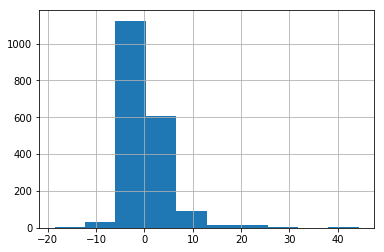

In [19]:
(real_valid_81 - predict_valid_81_sb).hist()

### Remember Sales quantity is integr in real life, just investigat how does rounding affects the error. Can talk about more in the report. Say we can build an calssifier in the future to justify when to round up, when to round dow, this is something that I sugeested (not sure if it is correct)

In [20]:
# round up
error  = real_valid_81.values - [math.ceil(i) for i in predict_valid_81_sb]
mae = sum([abs(i) for i in error])/len(error)
mae

2.3966244725738397

In [21]:
# round down 
error  = real_valid_81.values - [math.floor(i) for i in predict_valid_81_sb]
mae = sum([abs(i) for i in error])/len(error)
mae

2.25

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=real_valid_81, y=predict_valid_81_sb,
                    mode='markers',
                    name='Prediction/Actual'))
fig.add_trace(go.Scatter(x=np.linspace(0,real_valid_81.max()), y=np.linspace(0,real_valid_81.max()),
                    mode='lines',
                    name='perfect prediction'))

fig.update_layout(
    title="Result Visualisation for week 81 LGBM",
    xaxis_title="Actual",
    yaxis_title="Prediction",
)
fig.show()

In [23]:
def rolling_forecaster_expansion_valid(lag,train,test,model):

    """
    input: Lag: the maximum looking back peroid, here is 2 
           train: the training data set 
           test: the test data set 
           model: model that we use 

    Output:   result_table: the result table, week, bkey, and predictions
              MAE: list of length 12, weekly MAE recorder
              
    """
    
    # OUTPUT 
    result_table = pd.DataFrame(columns = ['prediction','product_bkey1','reporting_date'])
    MAE = []
    R2 =[]
    
    # train_X and train_y split 
    train_X, train_y = train.drop(columns = ['sales_quantity']), train['sales_quantity']
    test_X, test_y = test.drop(columns = ['sales_quantity']), test['sales_quantity'] 

    #Standardisation and put back to pandas form 
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    train_X_s = pd.DataFrame(X_scaler.fit_transform(train_X), columns = train_X.columns,index = train_X.index )
    test_X_s = pd.DataFrame(X_scaler.transform(test_X), columns = test_X.columns,index = test_X.index)

    train_y_s = pd.Series(y_scaler.fit_transform(np.array(train_y).reshape(-1, 1)).flatten(), index = train_y.index)
    test_y_s = pd.Series(y_scaler.transform(np.array(test_y).reshape(-1, 1)).flatten(), index = test_y.index)

    #Utility variables
    # the iterrables to guide the on step forecasting session 
    date_slider = list(test_X_s['reporting_date'].unique())
  
    #train_scaled/valid_sacled, df with scaled value

    # columns that I need forward update
    sq_col = ['sales_quantity(t-1)','sales_quantity(t-2)','sales_quantity(t-1)-(t-2)']

    # data transformation & fit 
    pca = PCA(n_components=15)
    model.fit(pca.fit_transform(train_X_s),train_y_s)
    

    for i in range(len(date_slider)): 

        print('forecasting for week {} begins'.format(i))
        
        temp_X = test_X_s[test_X_s['reporting_date'] == test_X_s['reporting_date'].unique()[0]]
        temp_y = test_y_s[temp_X.index]

        # generate the point estimation 
        prediction_s = model.predict(pca.transform(temp_X))
        
        prediction = y_scaler.inverse_transform(prediction_s)
        temp_s_sb = y_scaler.inverse_transform(temp_y)
        
        # mae visualisation 
        mae = mean_absolute_error(temp_s_sb,prediction)
        r2 = r2_score(temp_s_sb,prediction)
        print('forecasting mae for week {} is {}'.format(i,mae))
        print('forecasting R^2 for week {} is {}'.format(i,r2))
        MAE.append(mae)
        R2.append(r2)

        # generate the dictionary that used to replace value in the feature 
        temp = temp_X.copy()
        temp['prediction'] = prediction_s
        temp = temp[['prediction','product_bkey1','reporting_date']]
    
        # update valid_X in the future 
        for j in range(1,lag+1): 

            if i+j <= len(date_slider) - 1: 

                # look up the weeks after the exsiting test set, all the way up to predefined lag
                    X_test_next_week_sq = test_X_s[test_X_s['reporting_date'] == date_slider[i+j]][sq_col + ['product_bkey1']]

                    # update the test set that we are going to use in the future with the local prediction 
                    temp2 = X_test_next_week_sq.reset_index().merge(temp, on='product_bkey1', how = 'inner').set_index('index')

                    temp2 = temp2.drop(columns = ['sales_quantity(t-'+str(j)+')'])
                    temp2 = temp2.rename(columns = {'prediction':'sales_quantity(t-'+str(j)+')'})
                    
                    if j == 1: 
                        temp2['sales_quantity(t-1)-(t-2)'] = temp2['sales_quantity(t-'+str(j)+')'] - temp2['sales_quantity(t-2)']
                    
                    index_to_update = temp2.index
                    test_X_s.loc[index_to_update][temp2.columns] = temp2
            else: 
                pass
    
        # chop the size of the test_X
        test_X_s = test_X_s.drop(temp_X.index)
        test_y_s = test_y_s.drop(temp_X.index)
        
        #### UNHASH here than the strategy becomes sliding window ###
        # push the size of trian_X and trian_y down by one week, sliding window
        #train_X_s = train_X[train_X_s['reporting_date'] > train_X_s['reporting_date'].unique()[0]]
        #train_y_s = train_y[train_X_s.index]

        # increase the size of train_X and train_y
        train_X_s = pd.concat([train_X_s, temp_X])
        train_y_s = pd.concat([train_y_s, pd.Series(prediction_s,index = temp_X.index)])
     
        #store the result
        #refit the model 
        pca.fit(train_X_s)
        model.fit(pca.transform(train_X_s),train_y_s) 

        result_table = pd.concat([result_table,temp])
        print('forecasting for week {} completes'.format(i))
        
    return result_table, MAE, R2

# Following rolling forecast use PCA n = 19

### In Sequential module, pca = 19 constnatly

In [39]:
model = LGBMRegressor(n_estimators=500, max_depth=20,reg_lambda = 100, random_state=RSEED, 
                      num_leaves= 100)
result_table, MAE, R2 = sequential.rolling_forecaster_expansion_valid(2,train,test,model)

forecasting for week 0 begins
forecasting mae for week 0 is 2.232999274852981
forecasting R^2 for week 0 is 0.944332030277971
forecasting for week 0 completes
forecasting for week 1 begins
forecasting mae for week 1 is 2.244565564604278
forecasting R^2 for week 1 is 0.933854659872599
forecasting for week 1 completes
forecasting for week 2 begins
forecasting mae for week 2 is 2.317716604185211
forecasting R^2 for week 2 is 0.9399589577055038
forecasting for week 2 completes
forecasting for week 3 begins
forecasting mae for week 3 is 3.0436422865169477
forecasting R^2 for week 3 is 0.765617024392699
forecasting for week 3 completes
forecasting for week 4 begins
forecasting mae for week 4 is 2.5421047405459367
forecasting R^2 for week 4 is 0.9379411719615801
forecasting for week 4 completes
forecasting for week 5 begins
forecasting mae for week 5 is 3.025997665932346
forecasting R^2 for week 5 is 0.897215577257689
forecasting for week 5 completes
forecasting for week 6 begins
forecasting 

In [40]:
# 12 week average result 
print('Mean Absolute Error = %.5f' % np.mean(MAE))
print('R2 = %.5f' % np.mean(R2))

Mean Absolute Error = 2.69196
R2 = 0.90721


## Since I know the best output is captured here. I outptu the model directly

In [41]:
import pickle
pickle.dump(model, open('LGBM_Regressor', 'wb'))
#loaded_model = pickle.load(open('LGBM_Regressor', 'rb'))

# Following forecast use PCA = 15 

In [27]:
result_table_2, MAE_2, R2_2 = rolling_forecaster_expansion_valid(2,train,test,model)

forecasting for week 0 begins
forecasting mae for week 0 is 2.2734490844243855
forecasting R^2 for week 0 is 0.9434103190000521
forecasting for week 0 completes
forecasting for week 1 begins
forecasting mae for week 1 is 2.312577523848755
forecasting R^2 for week 1 is 0.9297172158300866
forecasting for week 1 completes
forecasting for week 2 begins
forecasting mae for week 2 is 2.400920723602378
forecasting R^2 for week 2 is 0.9337882759345943
forecasting for week 2 completes
forecasting for week 3 begins
forecasting mae for week 3 is 3.171104771374748
forecasting R^2 for week 3 is 0.7628567873022413
forecasting for week 3 completes
forecasting for week 4 begins
forecasting mae for week 4 is 2.7629546218484777
forecasting R^2 for week 4 is 0.912677835955211
forecasting for week 4 completes
forecasting for week 5 begins
forecasting mae for week 5 is 3.1256697608678934
forecasting R^2 for week 5 is 0.8914656513120158
forecasting for week 5 completes
forecasting for week 6 begins
forecast

In [28]:
# 12 week average result 
print('Mean Absolute Error = %.5f' % np.mean(MAE_2))
print('R2 = %.5f' % np.mean(R2_2))

Mean Absolute Error = 2.78736
R2 = 0.90086


# So for LGBM, let us use PCA 19, the error is much lower

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x= list(range(81,93)), 
                        y=MAE, 
                        mode='markers+lines',
                        name='MAE LGBM Regressor'))

fig.add_trace(go.Scatter(x= list(range(81,93)), 
                        y=MAE_b, 
                        mode='markers+lines',
                        name='MAE Baseline'))

fig.update_layout(
    title="LGBM Regressor",
    xaxis_title="Validation Week",
    yaxis_title="MAE",
)
fig.show()

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x= list(range(81,93)), 
                        y=R2, 
                        mode='markers+lines',
                        name='R^2 LGBM Regressor'))

fig.add_trace(go.Scatter(x= list(range(81,93)), 
                        y=R2_b, 
                        mode='markers+lines',
                        name='R^2 Baseline'))
fig.update_layout(
    title="LGBM Regressor",
    xaxis_title="Validation Week",
    yaxis_title="R^2",
)
                    
fig.show()

## Output  has the same size with test, all good 

In [31]:
print(test_y.shape)
print(result_table['prediction'] .shape)

(17024,)
(17024,)


In [32]:
prediction = y_scaler.inverse_transform(result_table['prediction'])

In [33]:
result_table['prediction_sb'] = prediction
result_table['y_real'] = test_y
result_table['error'] = result_table['y_real'] - result_table['prediction_sb']

In [34]:
result_table.head()

,prediction,product_bkey1,reporting_date,prediction_sb,y_real,error
927373,-0.290591,0.780765,1.361673,2.541818,3.0,0.458182
926553,-0.343016,1.833676,1.361673,1.515946,1.0,-0.515946
920678,-0.131459,-1.527011,1.361673,5.655740,4.0,-1.655740
920686,-0.379173,-0.382909,1.361673,0.808432,1.0,0.191568
920697,0.114222,-1.523452,1.361673,10.463252,4.0,-6.463252


In [35]:
px.histogram(result_table,'error',nbins=60)

In [36]:
result_table['error'].mean()

0.18297044350188366

In [37]:
result_table.head()

,prediction,product_bkey1,reporting_date,prediction_sb,y_real,error
927373,-0.290591,0.780765,1.361673,2.541818,3.0,0.458182
926553,-0.343016,1.833676,1.361673,1.515946,1.0,-0.515946
920678,-0.131459,-1.527011,1.361673,5.655740,4.0,-1.655740
920686,-0.379173,-0.382909,1.361673,0.808432,1.0,0.191568
920697,0.114222,-1.523452,1.361673,10.463252,4.0,-6.463252


In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result_table['y_real'], y=result_table['prediction_sb'],
                    mode='markers',
                    name='Prediction/Actual'))

fig.add_trace(go.Scatter(x=np.linspace(0,result_table['y_real'].max()), y=np.linspace(0,result_table['y_real'].max()),
                    mode='lines',
                    name='perfect prediction'))

fig.update_layout(
    title="Result Visualisation all 12 weeks validation",
    xaxis_title="Actual",
    yaxis_title="Prediction",
)
fig.show()